<a href="https://colab.research.google.com/github/Ogweno/portfolio/blob/main/Lawn_Grass_Edge_Detection_Segmentation_UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras-tuner


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.1/172.1 KB 4.3 MB/s eta 0:00:00


In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tnrange
from tqdm.notebook import tqdm

from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
#from keras.layers.merge import concatenate, add
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, add, UpSampling2D

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

import kerastuner
from tensorflow import keras
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

#from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [ ]:
# Set some parameters
im_width = 128
im_height = 128
border = 5

In [ ]:
ids = next(os.walk("images"))[2] # list of names all images in the given path
print("No. of images = ", len(ids))

No. of images =  66


Convert the images to np array

In [ ]:
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

#### Load the images and masks into arrays

In [ ]:
# tqdm is used to display the progress bar
for n, id_ in tqdm(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img("images/"+id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = img_to_array(load_img("masks/"+id_, grayscale=True))
    mask = resize(mask, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0


  0%|          | 0/66 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/keras/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


In [ ]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

#### Below code can be used to visualize the images and corresponding masks

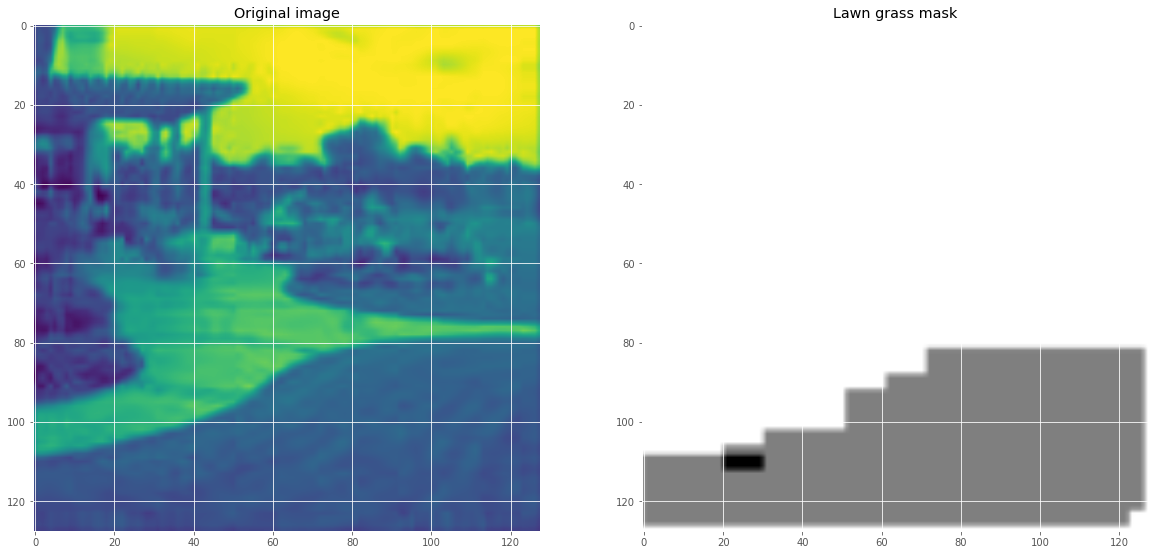

In [ ]:
# Select a random image from the training set
ix = random.randint(0, len(X_train))

# Check if the image contains lawn grass
has_mask = y_train[ix].max() > 0

# Define colormap for image
img_cmap = None # Default colormap for true colors

# Define colormap for mask
mask_cmap = 'binary' # Black and white colormap to display the mask

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 15))

# Display the original image
ax1.imshow(X_train[ix], cmap=img_cmap, interpolation='bilinear')
ax1.set_title('Original image')

if has_mask:
    # Draw a boundary (contour) in the original image separating lawn grass and non-lawn areas
    ax1.contour(y_train[ix].squeeze(), colors='k', linewidths=5, levels=[0.5])
    # Display the mask in black and white
    ax2.imshow(y_train[ix].squeeze(), cmap=mask_cmap, interpolation='bilinear')
    ax2.set_title('Lawn grass mask')
else:
    # Display the original image with the default colormap for true colors
    ax2.imshow(X_train[ix], cmap=img_cmap, interpolation='bilinear')
    ax2.set_title('No lawn grass mask')

plt.show()


In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

**Define the UNET architecture**

U-Net model, loosely based on U-Net: Convolutional Networks for Biomedical Image Segmentation

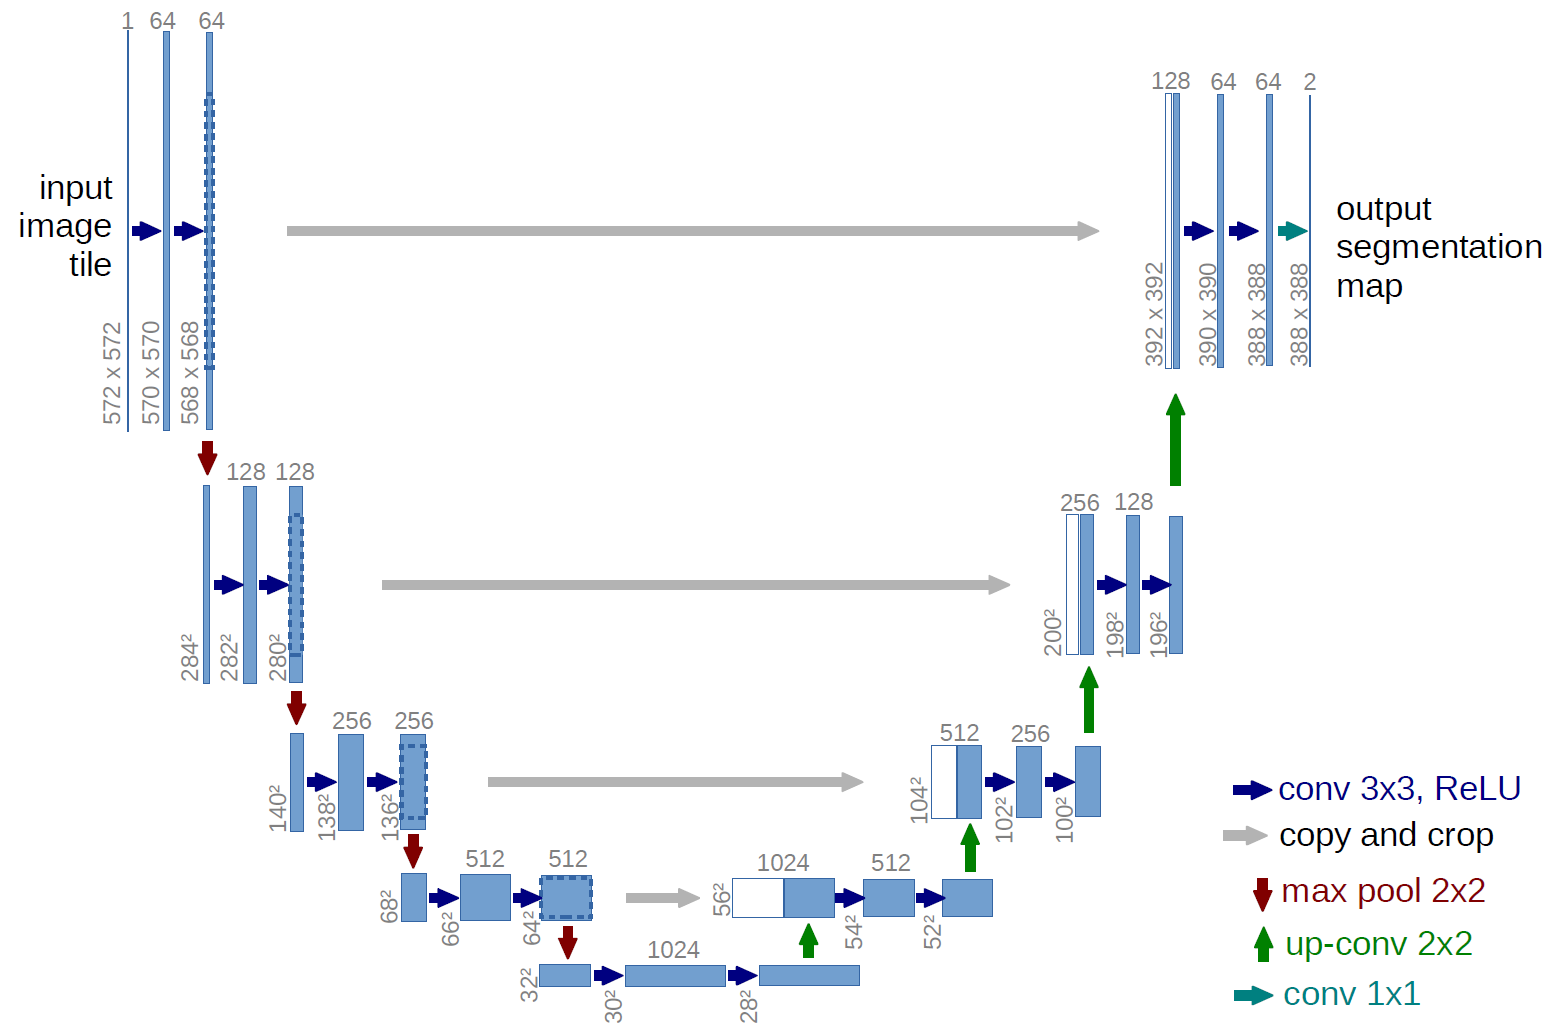
Model Architecture   Source:https://arxiv.org/abs/1505.04597


In [ ]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)

    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)

    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)

    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)

    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 16  160         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 128, 128, 16  64         ['conv2d_1[0][0]']               
 rmalization)                   )                                                             

In [ ]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-lawn_edge.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
results = model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Epoch 1/50
2/2 [==============================] - ETA: 0s - loss: 0.9724 - accuracy: 0.2506
Epoch 1: val_loss improved from inf to 0.54204, saving model to model-lawn_edge.h5
2/2 [==============================] - 12s 5s/step - loss: 0.9724 - accuracy: 0.2506 - val_loss: 0.5420 - val_accuracy: 0.8135 - lr: 0.0010
Epoch 2/50
2/2 [==============================] - ETA: 0s - loss: 0.9056 - accuracy: 0.2578
Epoch 2: val_loss did not improve from 0.54204
2/2 [==============================] - 7s 3s/step - loss: 0.9056 - accuracy: 0.2578 - val_loss: 0.7363 - val_accuracy: 0.4839 - lr: 0.0010
Epoch 3/50
2/2 [==============================] - ETA: 0s - loss: 0.8398 - accuracy: 0.3063
Epoch 3: val_loss did not improve from 0.54204
2/2 [==============================] - 8s 3s/step - loss: 0.8398 - accuracy: 0.3063 - val_loss: 2.0648 - val_accuracy: 0.1767 - lr: 0.0010
Epoch 4/50
2/2 [==============================] - ETA: 0s - loss: 0.7797 - accuracy: 0.3902
Epoch 4: val_loss did not improve fro

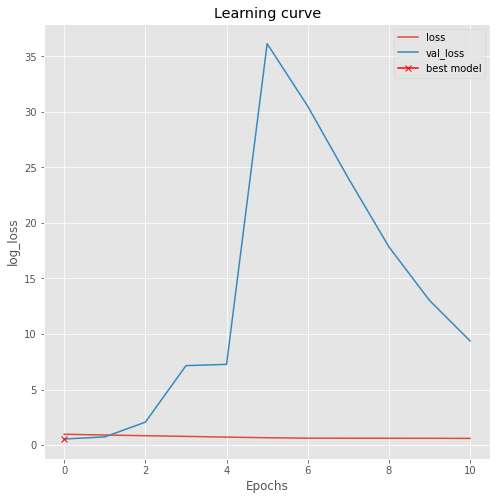

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

### Inference

In [ ]:
# load the best model
model.load_weights('model-lawn_edge.h5')

In [ ]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

1/1 [==============================] - 0s 399ms/step - loss: 0.5420 - accuracy: 0.8135


[0.5420421957969666, 0.8134722113609314]

In [ ]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

1/1 [==============================] - 0s 376ms/step


In [ ]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

Visualizing sample plots

In [ ]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    #img_cmap = 'Greens' # greenish colormap to represent grass/lawn
    #ax[0].imshow(X_train[ix, ..., 0], cmap=img_cmap, interpolation='bilinear')
    ax[0].imshow(X[ix, ..., 0], cmap='PuBuGn_r')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Original Image')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Lawn Grass Mask')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Lawn Grass Boundary Predicted')

    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Lawn Grass Boundary Predicted binary');

In [ ]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    img_cmap = 'PuBuGn_r'
    ax[0].imshow(X[ix, ..., 0], cmap=img_cmap, interpolation='bilinear')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', linewidths=3, levels=[0.5])
    ax[0].set_title('Original Image')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Lawn Grass Mask')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', linewidths=3, levels=[0.5])
    ax[2].set_title('Lawn Grass Boundary Predicted')

    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', linewidths=3, levels=[0.5])
    ax[3].set_title('Lawn Grass Boundary Predicted binary')


In [ ]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    img_cmap = 'PuBuGn_r'
    ax[0].imshow(X[ix, ..., 0], cmap=img_cmap, interpolation='bilinear')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', linewidths=3, levels=[0.5])
    ax[0].set_title('Original Image')

    ax[1].imshow(y[ix].squeeze(), cmap='gray', interpolation='bilinear')
    ax[1].set_title('Lawn Grass Mask')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', linewidths=3, levels=[0.5])
    ax[2].set_title('Lawn Grass Boundary Predicted')

    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1, interpolation='bilinear')
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', linewidths=3, levels=[0.5])
    ax[3].set_title('Lawn Grass Boundary Predicted binary')


### Predictions on training set

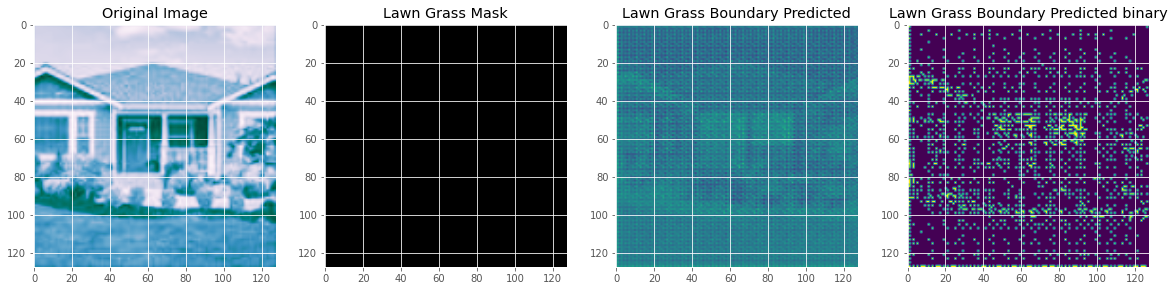

In [ ]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)

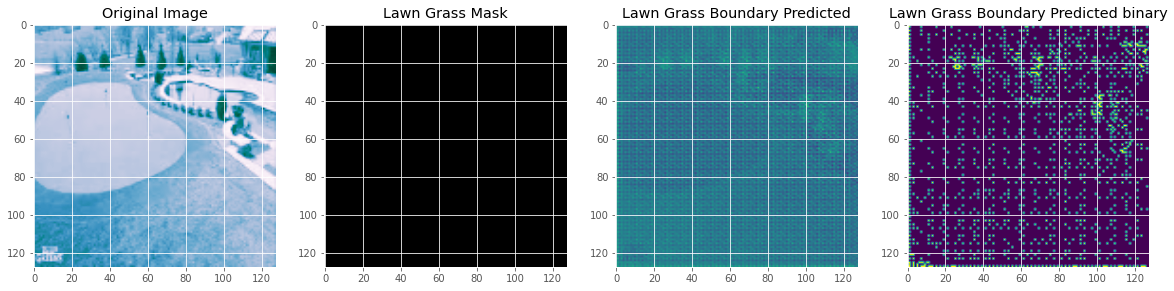

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

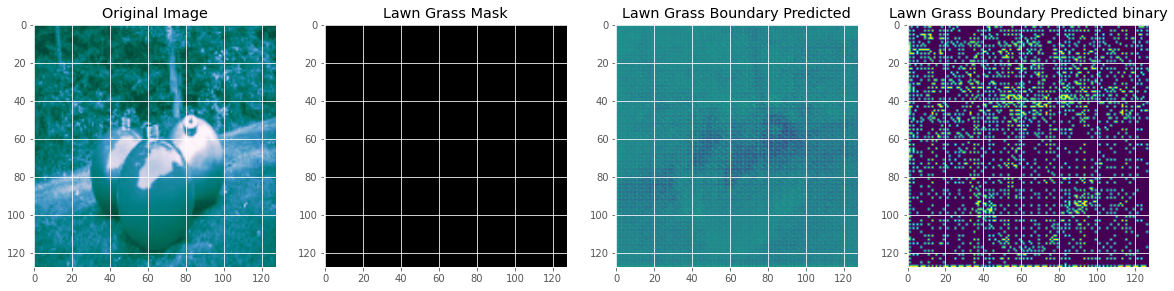

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

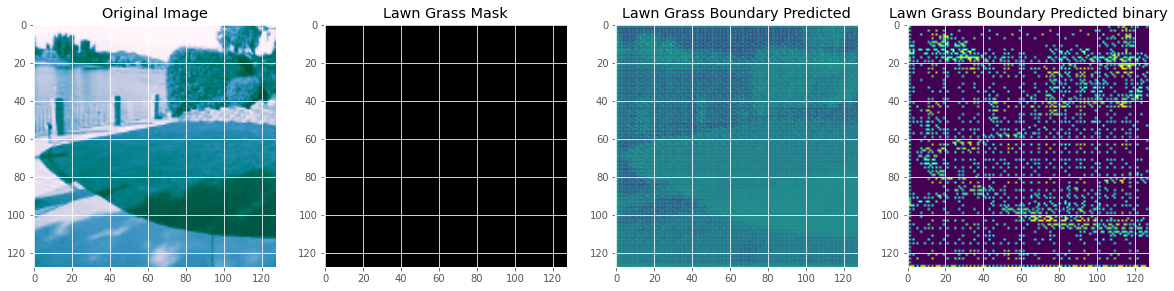

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

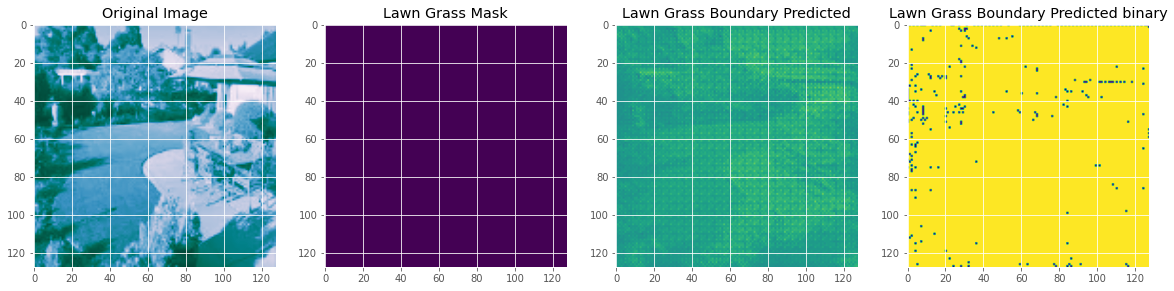

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

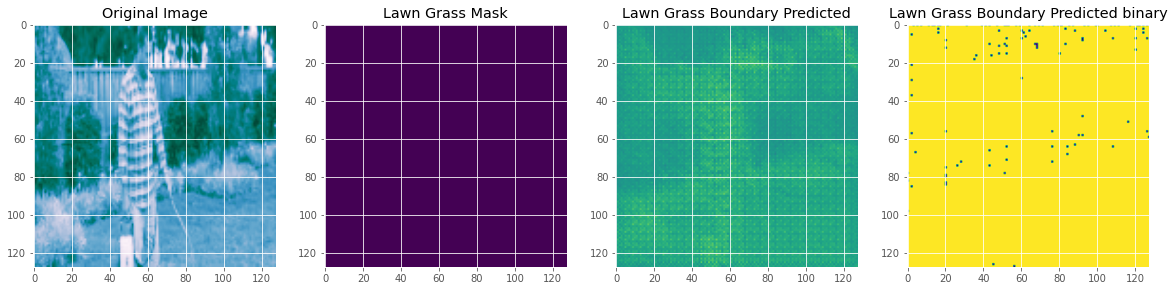

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

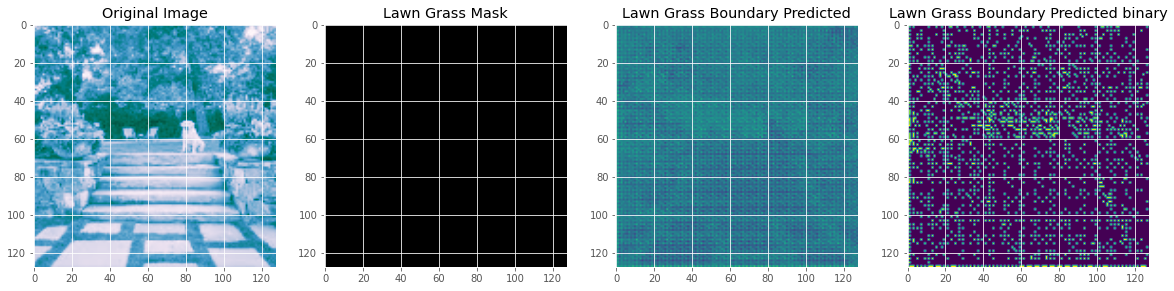

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

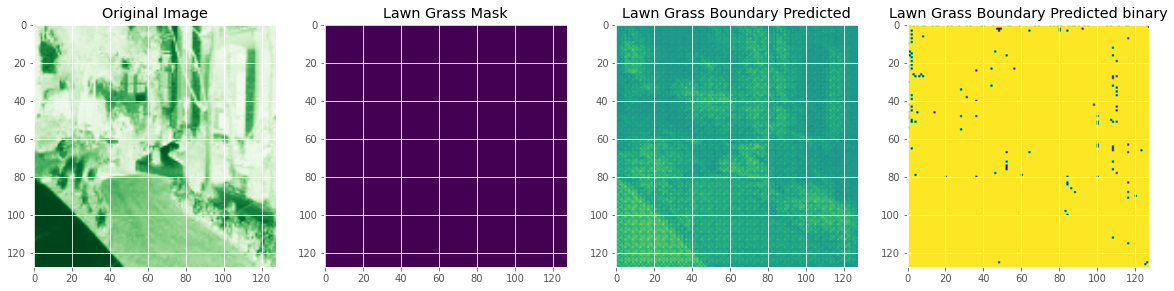

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

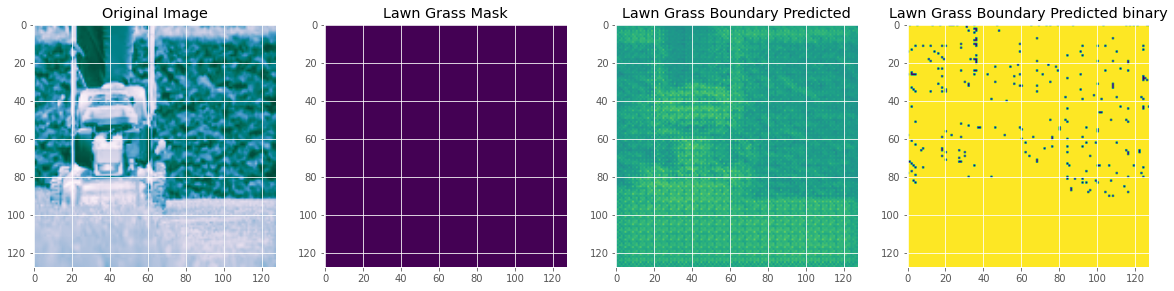

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

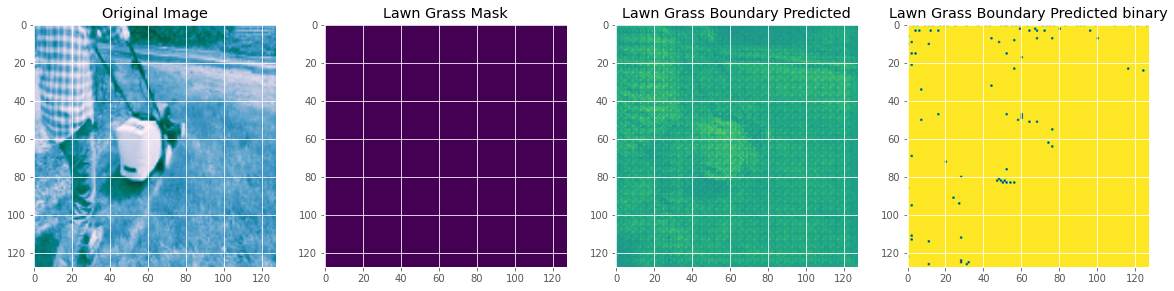

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

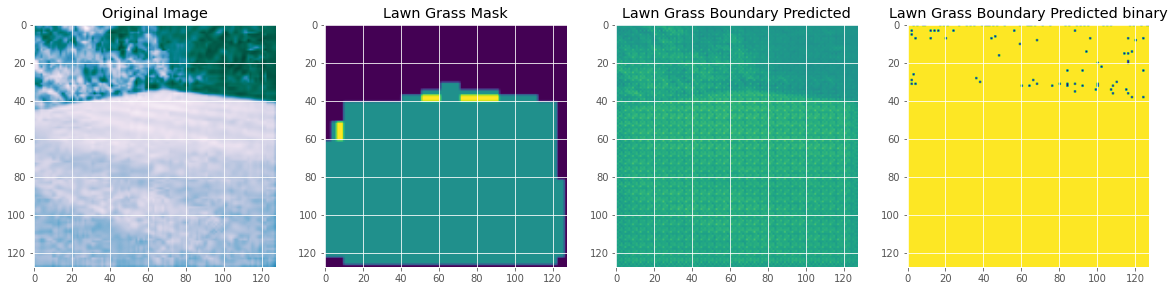

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

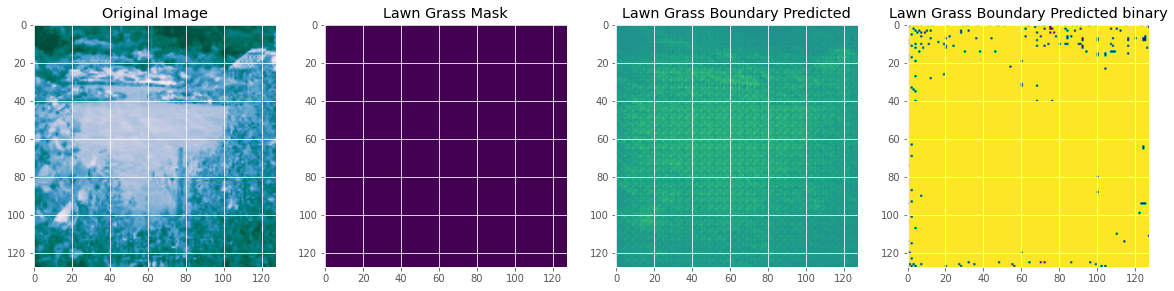

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

### Predictions on test set

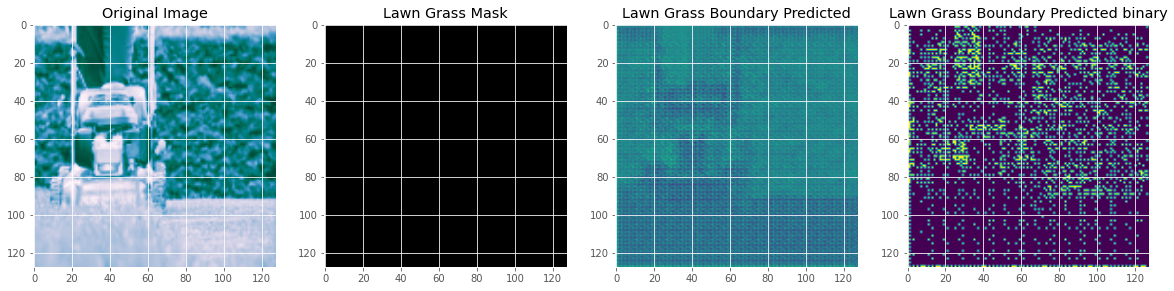

In [ ]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=1)

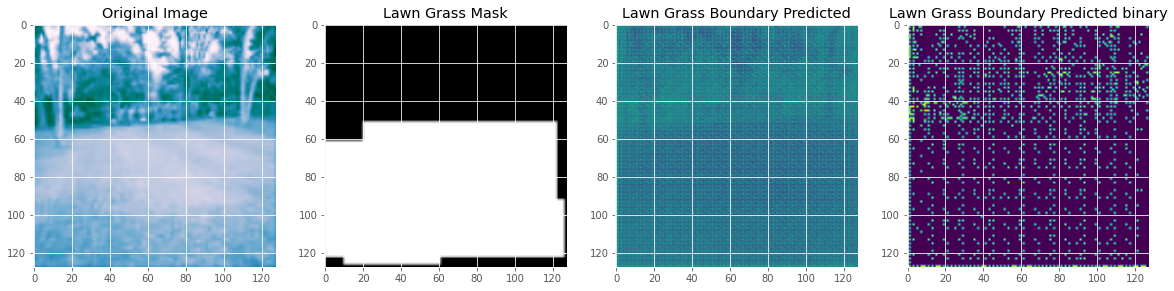

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

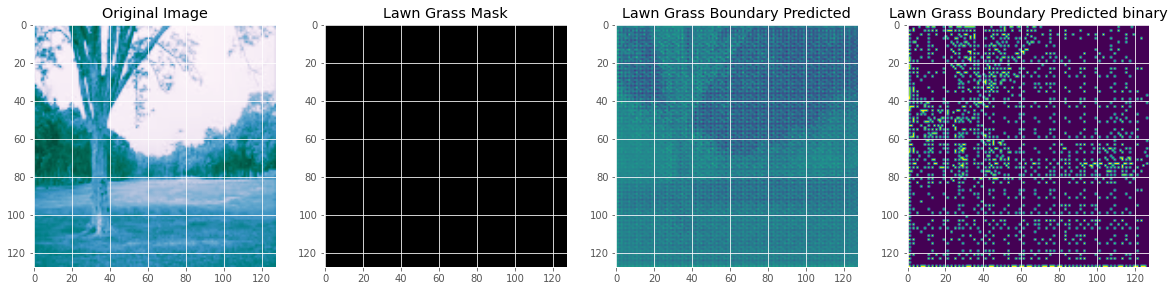

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

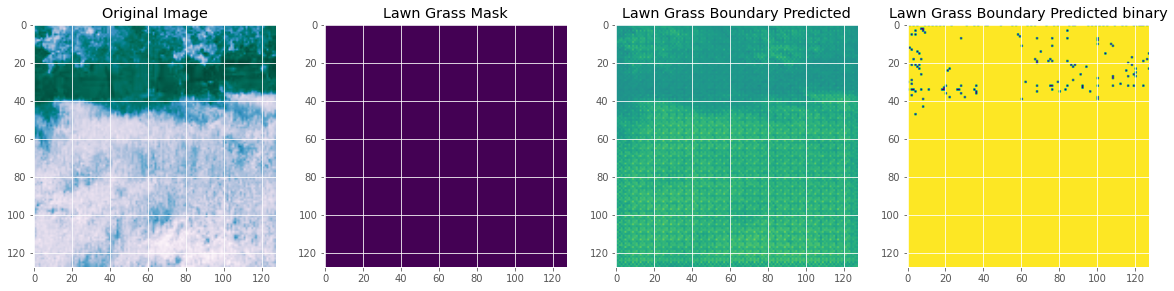

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

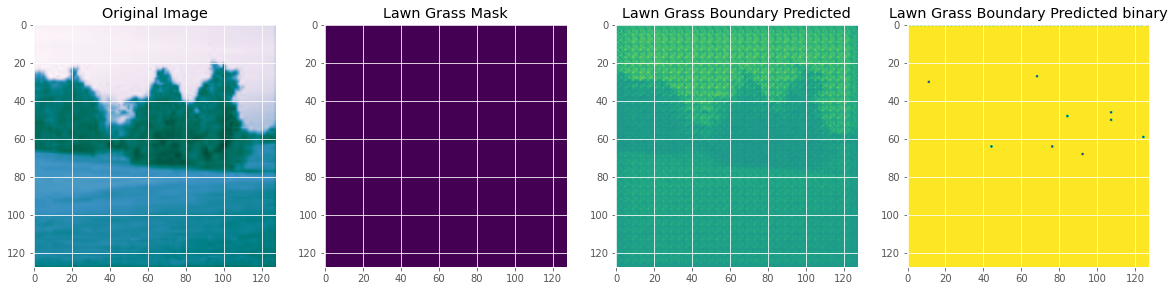

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

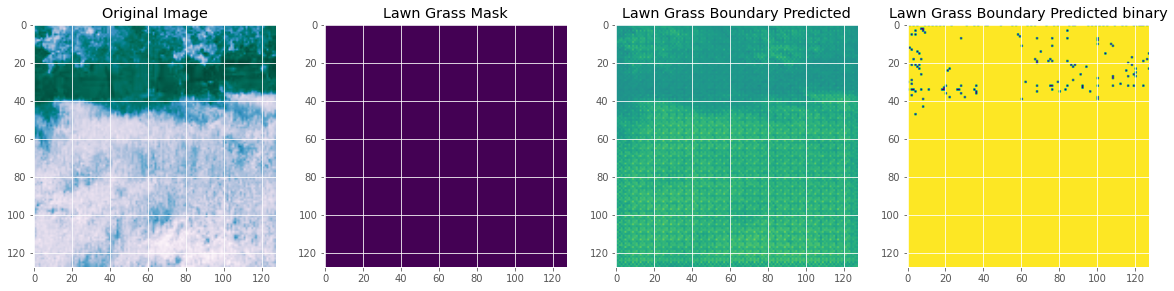

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

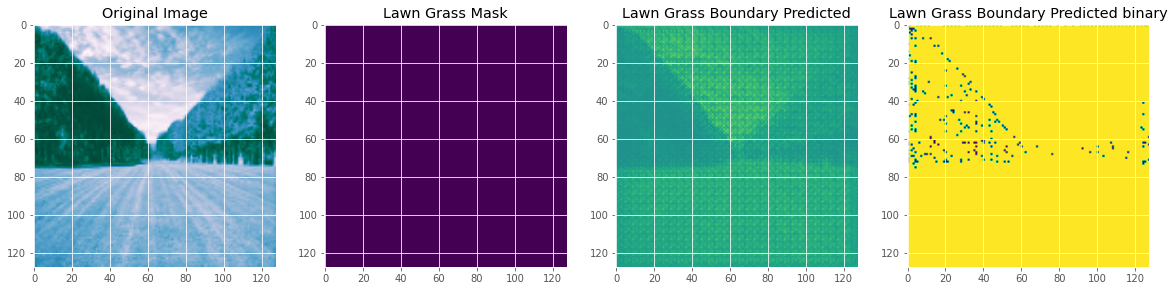

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

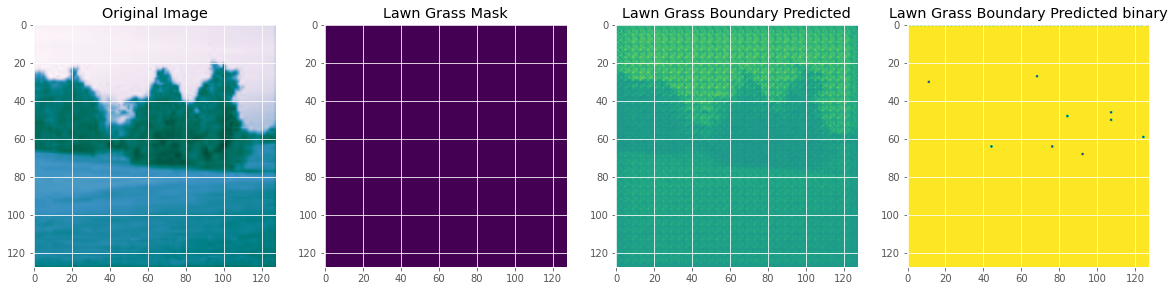

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

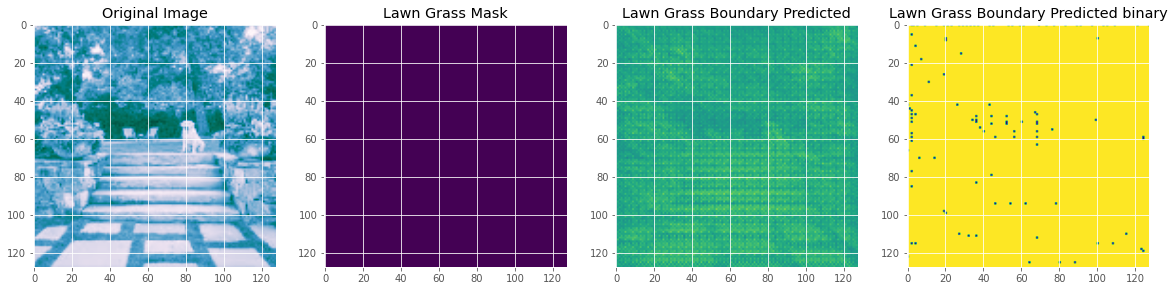

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

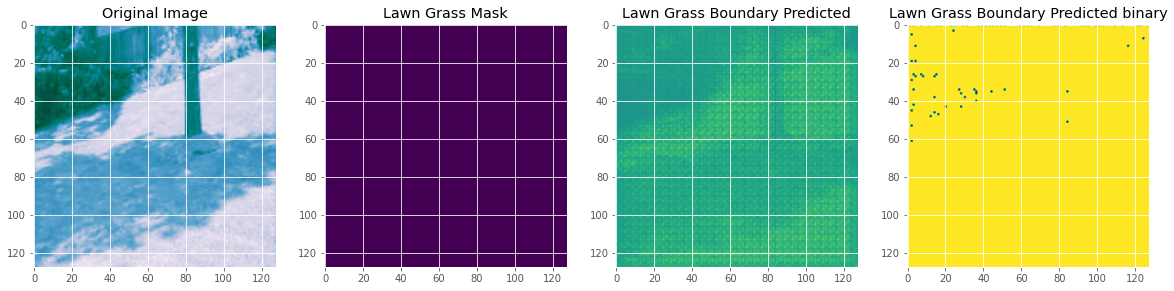

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

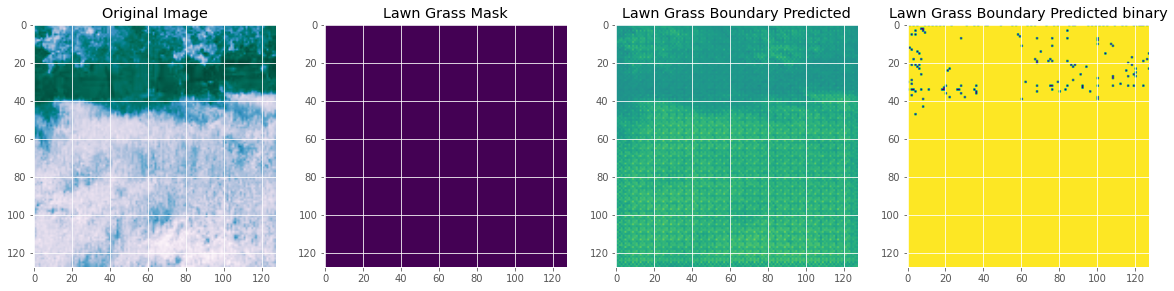

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

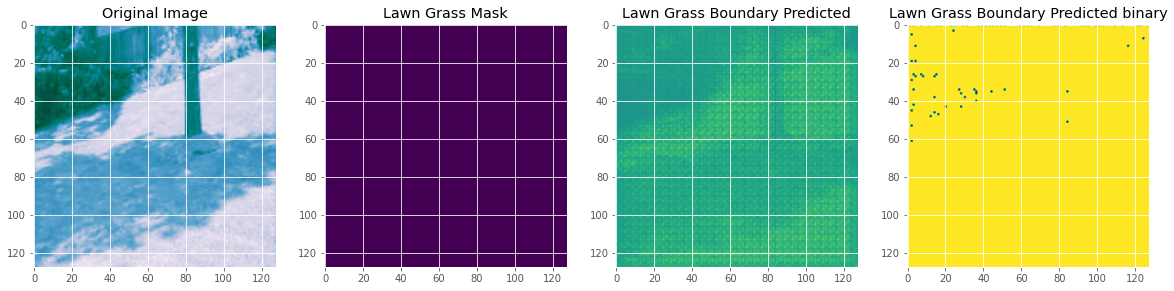

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

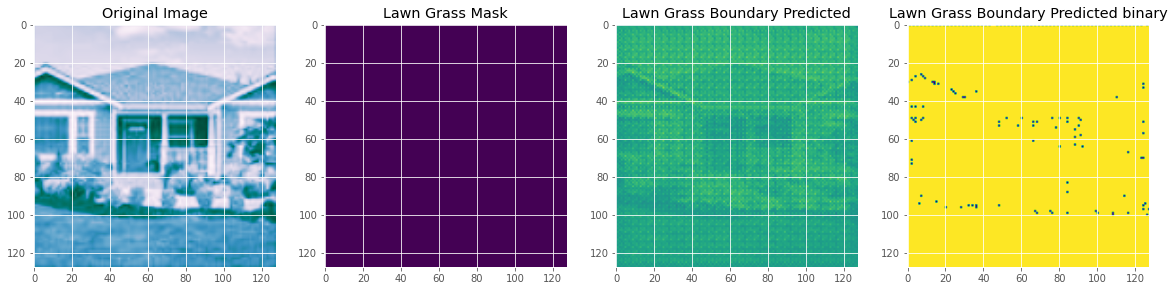

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

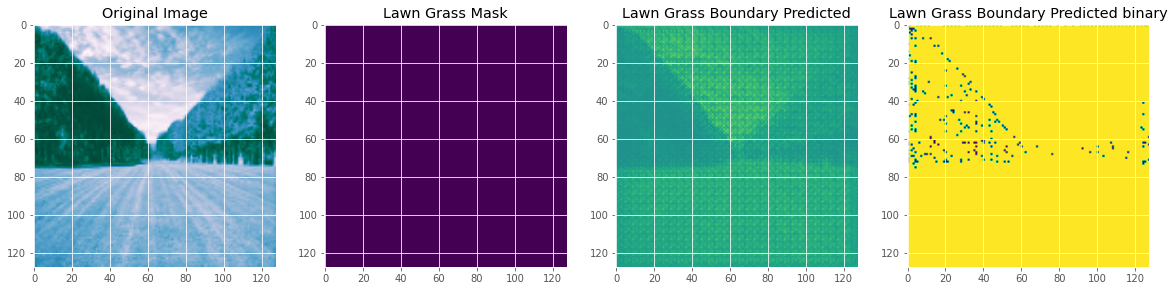

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

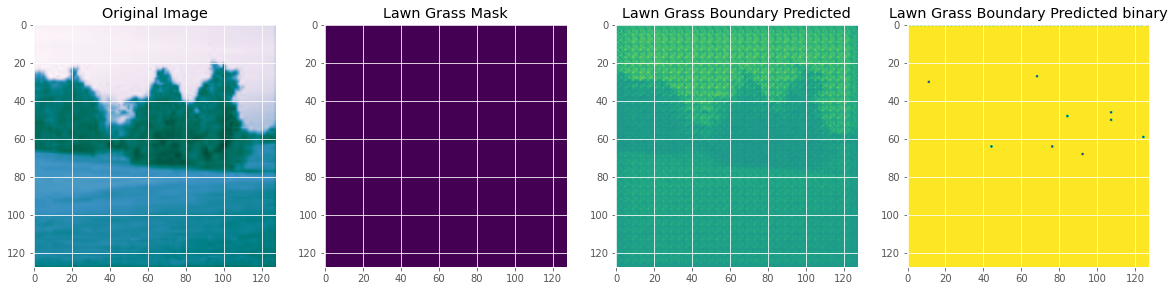

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

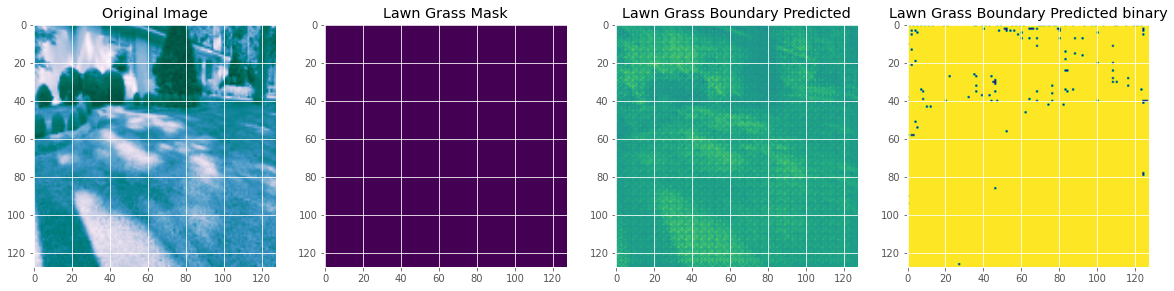

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

Hyper-parameters tuning

In [ ]:
def build_model(hp):
    inputs = keras.Input(shape=(128, 128, 3))
    x = inputs

    # Add convolutional layers
    for i in range(hp.Int('conv_layers', min_value=1, max_value=4)):
        filters = hp.Int('filters_' + str(i), min_value=32, max_value=512, step=32)
        x = keras.layers.Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation='relu')(x)

    # Add pooling layers
    for i in range(hp.Int('pooling_layers', min_value=1, max_value=4)):
        x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Add upsampling layers
    for i in range(hp.Int('upsampling_layers', min_value=1, max_value=4)):
        filters = hp.Int('filters_' + str(i), min_value=32, max_value=512, step=32)
        x = keras.layers.Conv2DTranspose(filters=filters, kernel_size=(3, 3), padding='same', activation='relu')(x)

    # Output layer
    outputs = keras.layers.Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(x)

    # Compile the model
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])

    return model

def hyperparameter_tuning(X_train, y_train, X_val, y_val):
    tuner = RandomSearch(build_model,
                         #objective='val_mean_io_u',
                         objective=kerastuner.Objective('val_mean_io_u', direction='max'),
                         max_trials=10,
                         executions_per_trial=1,
                         directory='unet_hyperparam_tuning',
                         project_name='lawn_segmentation')

    tuner.search_space_summary()

    tuner.search(x=X_train,
                 y=y_train,
                 epochs=10,
                 batch_size=16,
                 validation_data=(X_val, y_val))

    # Get the best hyperparameters
    best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
    print("Best hyperparameters:")
    print(best_hp.values)

    # Build and compile the model with the best hyperparameters
    model = build_model(best_hp)
    model.summary()

    return model


In [ ]:
hyperparameter_tuning(X_train, y_train, X_valid, y_valid)

Trial 2 Complete [00h 00m 01s]

Best val_mean_io_u So Far: None
Total elapsed time: 00h 00m 01s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
4                 |3                 |conv_layers
32                |480               |filters_0
3                 |3                 |pooling_layers
1                 |1                 |upsampling_layers
0.01              |0.01              |learning_rate
128               |32                |filters_1
288               |32                |filters_2
480               |None              |filters_3

Epoch 1/10


Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/keras_tuner/engine/base_tuner.py", line 266, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.9/dist-packages/keras_tuner/engine/base_tuner.py", line 231, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.9/dist-packages/keras_tuner/engine/tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.9/dist-packages/keras_tuner/engine/tuner.py", line 214, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/usr/local/lib/python3.9/dist-packages/keras_tuner/engine/hypermodel.py", line 144, in fit
    return model.fit(*args, **kwargs)
  File "/usr/local/lib/python3.9/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.wi

RuntimeError: ignored

In [ ]:
def load_data():
    ids = os.listdir("images")
    X = np.zeros((len(ids), 128, 128, 3), dtype=np.float32)
    y = np.zeros((len(ids), 128, 128, 1), dtype=np.float32)

    for n, id_ in tqdm(enumerate(ids), total=len(ids)):
        # Load images
        img = load_img("images/"+id_, grayscale=True)
        x_img = img_to_array(img)
        x_img = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)
        # Load masks
        mask = img_to_array(load_img("masks/"+id_, grayscale=True))
        mask = resize(mask, (128, 128, 1), mode = 'constant', preserve_range = True)
        # Save images
        X[n] = x_img/255.0
        y[n] = mask/255.0

    return X, y

In [ ]:
def build_model(hp):
    inputs = keras.Input(shape=(128, 128, 3))
    x = inputs

    # Add convolutional layers
    for i in range(hp.Int('conv_layers', min_value=1, max_value=4)):
        filters = hp.Int('filters_' + str(i), min_value=32, max_value=512, step=32)
        x = keras.layers.Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation='relu')(x)

    # Add pooling layers
    for i in range(hp.Int('pooling_layers', min_value=1, max_value=4)):
        x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Add upsampling layers
    for i in range(hp.Int('upsampling_layers', min_value=1, max_value=4)):
        filters = hp.Int('filters_' + str(i), min_value=32, max_value=512, step=32)
        x = keras.layers.Conv2DTranspose(filters=filters, kernel_size=(3, 3), padding='same', activation='relu')(x)

    # Output layer
    outputs = keras.layers.Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(x)

    # Compile the model
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])

    return model

In [ ]:
def hyperparameter_tuning(X_train, y_train, X_val, y_val):
    tuner = RandomSearch(build_model,
                         objective = keras_tuner.Objective("val_mean_io_u", direction="max"),
                         max_trials=10,
                         executions_per_trial=1,
                         directory='unet_hyperparam_tuning',
                         project_name='lawn_segmentation')

    tuner.search_space_summary()

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import kerastuner as kt

def build_model(input_shape, num_classes, hp):
    inputs = Input(shape=input_shape)
    x = inputs

    # Add convolutional layers
    for i in range(hp.Int('conv_layers', min_value=1, max_value=4)):
        filters = hp.get('filters_' + str(i))
        x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation='relu')(x)

    # Add pooling layers
    for i in range(hp.get('pooling_layers')):
        x = MaxPooling2D(pool_size=(2, 2))(x)

    # Add upsampling layers
    for i in range(hp.get('upsampling_layers')):
        filters = hp.get('filters_' + str(i))
        x = Conv2DTranspose(filters=filters, kernel_size=(3, 3), padding='same', activation='relu')(x)

    # Output layer
    outputs = Conv2D(filters=num_classes, kernel_size=(1, 1), activation='softmax')(x)

    # Compile the model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=keras.optimizers.Adam(hp.get('learning_rate')),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model



def hyperparameter_tuning(X_train, y_train, X_val, y_val):
    tuner = kt.Hyperband(
        hypermodel=lambda hp: build_model(input_shape=X_train.shape[1:], num_classes=y_train.shape[-1], hp=hp),
        objective='val_accuracy',
        max_epochs=10,
        factor=3,
        directory='unet_hyperparam_tuning',
        project_name='lawn_segmentation',overwrite=True
    )

    tuner.search_space_summary()

    tuner.search(x=X_train,
                 y=y_train,
                 epochs=10,
                 batch_size=16,
                 validation_data=(X_val, y_val))

    # Get the best hyperparameters
    best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
    print("Best hyperparameters:")
    print(best_hp.values)

    # Build and compile the model with the best hyperparameters
    model = build_model(input_shape=X_train.shape[1:], num_classes=y_train.shape[-1], hp=best_hp)
    model.summary()

    return model
